## 텐서플로 회귀 모델 만들기
* [자동차 연비 예측하기: 회귀  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/regression)

In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

import tensorflow as tf
from tqdm import tqdm
import tensorflow_addons as tfa

from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [3]:
df = pd.read_csv("http://bit.ly/data-diabetes-csv")
df.shape

(768, 9)

In [5]:
# Insulin 값이 0보다 큰 값만 사용합니다.
# df
df = df[df['Insulin'] > 0]
print('df.shape :',df.shape)
df.head()

df.shape : (394, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1


In [6]:
# label_name 을 Insulin 으로 합니다.
label_name = 'Insulin'

In [7]:
# train, test 데이터셋을 pandas 의 sample을 사용해서 8:2로 나눕니다.
train = df.sample(frac = 0.8, random_state=42)
test = df.drop(train.index)

print(train.shape, test.shape)

(315, 9) (79, 9)


In [89]:
X_train = train.drop(label_name, axis=1)
y_train = train[label_name]
X_test = test.drop(label_name, axis=1)
y_test = test[label_name]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(315, 8) (315,)
(79, 8) (79,)


In [229]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(315, 8)
(79, 8)


<img src="https://cs231n.github.io/assets/nn1/neural_net.jpeg" width="30%"> <img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

## 딥러닝 레이어 만들기

* [자동차 연비 예측하기: 회귀  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/regression)

* 층 설정
    * 신경망의 기본 구성 요소는 층(layer)입니다. 
    * 층은 주입된 데이터에서 표현을 추출합니다. 
    * 대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. 
    * tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

* Dense Layer: 
    * 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 
    * 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 
    * 마지막 층은 출력층 입니다.
        * 소프트맥스 일 때 : 2개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 2개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 
        * 각 노드는 현재 이미지가 2개 클래스 중 하나에 속할 확률을 출력합니다.
        * 시그모이드 일 때 : 둘 중 하나를 예측할 때 1개의 출력값을 출력합니다. 확률을 받아 임계값 기준으로 True, False로 나눕니다.
    
    
* 출력층 :
    * 예측 값이 n개 일 때 :  tf.keras.layers.Dense(n, activation='softmax')
    * 예측 값이 둘 중 하나일 때 : tf.keras.layers.Dense(1, activation='sigmoid')
    
    
* 드롭아웃(dropout)은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나입니다. 토론토(Toronto) 대학의 힌튼(Hinton)과 그의 제자들이 개발했습니다. 드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다(즉, 0으로 만듭니다). 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보죠. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됩니다. 예를 들면, [0, 0.5, 1.3, 0, 1.1]가 됩니다. "드롭아웃 비율"은 0이 되는 특성의 비율입니다. 보통 0.2에서 0.5 사이를 사용합니다. 테스트 단계에서는 어떤 유닛도 드롭아웃하지 않습니다. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄입니다.

* tf.keras에서는 Dropout 층을 이용해 네트워크에 드롭아웃을 추가할 수 있습니다. 이 층은 바로 이전 층의 출력에 드롭아웃을 적용합니다. (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [208]:
# tensorflow 를 tf로 불러오기
import tensorflow as tf

In [230]:
# input_shape 값을 구합니다. feature의 수로 만듭니다.
input_shape = X_train.shape[1]
input_shape

8

In [265]:
# 입력 레이어를 Input 레이어로 사용할 수도 있습니다.  tf.keras.layers.Input(shape=(input_shape))
# 분류와 똑같지만 회귀는 출력을 하나로 합니다.  tf.keras.layers.Dense(1)

init = tf.keras.initializers.GlorotNormal()
reg = tf.keras.regularizers.L2(l2=0.01)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=[input_shape]),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=128, activation='swish'),
    tf.keras.layers.Dense(units=128, activation='swish'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='swish'),
    tf.keras.layers.Dense(units=64, activation='swish'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='swish'),
    tf.keras.layers.Dense(units=32, activation='swish'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='swish'),
    tf.keras.layers.Dense(units=16, activation='swish'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),         
])
model

### 모델 컴파일
모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

* 옵티마이저(Optimizer) - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.
* 지표(Metrics) - 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.


* 손실 함수(Loss function) - 훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다. 최적의 가중치를 찾도록 해야함
    * 회귀  : MSE, MAE
    * 분류 : 
        * binary_crossentropy
        * categorical_crossentropy(one-hot형태의 클래스 예: [0, 1, 0, 0])
        * sparse_categorical_crossentropy(정답값이 0, 1, 2, 3, 4 와 같은 형태일 때)


In [266]:
# 모델을 컴파일 합니다.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer_use = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule)
model.compile(loss='mse', optimizer=optimizer_use, metrics=['mae','mse'])

In [267]:
# 모델을 요약합니다.
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 256)               2304      
                                                                 
 dense_106 (Dense)           (None, 128)               32896     
                                                                 
 dropout_44 (Dropout)        (None, 128)               0         
                                                                 
 dense_107 (Dense)           (None, 128)               16512     
                                                                 
 dense_108 (Dense)           (None, 128)               16512     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_109 (Dense)           (None, 64)              

## 학습
* 에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

In [268]:
# 모델을 학습합니다.
# 학습결과를 history 변수에 할당합니다.
# CallBack Functions
checkpoint_dir = 'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'
patience_time = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=patience_time)
cp = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, verbose=1,
                                       save_weights_only = True,
                                       save_best_only = True)

In [269]:
# history 
tqdm_callback = tfa.callbacks.TQDMProgressBar()

start = time.time()
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2,
                   batch_size=32, verbose=0,
                   callbacks=[early_stopping, cp, tqdm_callback])
end = time.time()
history

Training:   0%|                                                                               0/100 ETA: ?s,  …

Epoch 1/100


0/8                                                                                                          E…


Epoch 1: val_loss improved from inf to 33692.73828, saving model to Training_checkpoint\cp-0001-33692.74.ckpt
Epoch 2/100


0/8                                                                                                          E…


Epoch 2: val_loss improved from 33692.73828 to 20928.93359, saving model to Training_checkpoint\cp-0002-20928.93.ckpt
Epoch 3/100


0/8                                                                                                          E…


Epoch 3: val_loss improved from 20928.93359 to 15701.86914, saving model to Training_checkpoint\cp-0003-15701.87.ckpt
Epoch 4/100


0/8                                                                                                          E…


Epoch 4: val_loss did not improve from 15701.86914
Epoch 5/100


0/8                                                                                                          E…


Epoch 5: val_loss improved from 15701.86914 to 15404.75293, saving model to Training_checkpoint\cp-0005-15404.75.ckpt
Epoch 6/100


0/8                                                                                                          E…


Epoch 6: val_loss did not improve from 15404.75293
Epoch 7/100


0/8                                                                                                          E…


Epoch 7: val_loss improved from 15404.75293 to 15065.06543, saving model to Training_checkpoint\cp-0007-15065.07.ckpt
Epoch 8/100


0/8                                                                                                          E…


Epoch 8: val_loss improved from 15065.06543 to 13223.82715, saving model to Training_checkpoint\cp-0008-13223.83.ckpt
Epoch 9/100


0/8                                                                                                          E…


Epoch 9: val_loss did not improve from 13223.82715
Epoch 10/100


0/8                                                                                                          E…


Epoch 10: val_loss did not improve from 13223.82715
Epoch 11/100


0/8                                                                                                          E…


Epoch 11: val_loss did not improve from 13223.82715
Epoch 12/100


0/8                                                                                                          E…


Epoch 12: val_loss did not improve from 13223.82715
Epoch 13/100


0/8                                                                                                          E…


Epoch 13: val_loss did not improve from 13223.82715
Epoch 14/100


0/8                                                                                                          E…


Epoch 14: val_loss did not improve from 13223.82715
Epoch 15/100


0/8                                                                                                          E…


Epoch 15: val_loss did not improve from 13223.82715
Epoch 16/100


0/8                                                                                                          E…


Epoch 16: val_loss did not improve from 13223.82715
Epoch 17/100


0/8                                                                                                          E…


Epoch 17: val_loss did not improve from 13223.82715
Epoch 18/100


0/8                                                                                                          E…


Epoch 18: val_loss did not improve from 13223.82715
Epoch 19/100


0/8                                                                                                          E…


Epoch 19: val_loss did not improve from 13223.82715
Epoch 20/100


0/8                                                                                                          E…


Epoch 20: val_loss did not improve from 13223.82715
Epoch 21/100


0/8                                                                                                          E…


Epoch 21: val_loss did not improve from 13223.82715
Epoch 22/100


0/8                                                                                                          E…


Epoch 22: val_loss did not improve from 13223.82715
Epoch 23/100


0/8                                                                                                          E…


Epoch 23: val_loss did not improve from 13223.82715
Epoch 24/100


0/8                                                                                                          E…


Epoch 24: val_loss did not improve from 13223.82715
Epoch 25/100


0/8                                                                                                          E…


Epoch 25: val_loss did not improve from 13223.82715
Epoch 26/100


0/8                                                                                                          E…


Epoch 26: val_loss did not improve from 13223.82715
Epoch 27/100


0/8                                                                                                          E…


Epoch 27: val_loss did not improve from 13223.82715
Epoch 28/100


0/8                                                                                                          E…


Epoch 28: val_loss did not improve from 13223.82715
Epoch 29/100


0/8                                                                                                          E…


Epoch 29: val_loss did not improve from 13223.82715
Epoch 30/100


0/8                                                                                                          E…


Epoch 30: val_loss did not improve from 13223.82715
Epoch 31/100


0/8                                                                                                          E…


Epoch 31: val_loss did not improve from 13223.82715
Epoch 32/100


0/8                                                                                                          E…


Epoch 32: val_loss did not improve from 13223.82715
Epoch 33/100


0/8                                                                                                          E…


Epoch 33: val_loss did not improve from 13223.82715
Epoch 34/100


0/8                                                                                                          E…


Epoch 34: val_loss did not improve from 13223.82715
Epoch 35/100


0/8                                                                                                          E…


Epoch 35: val_loss did not improve from 13223.82715
Epoch 36/100


0/8                                                                                                          E…


Epoch 36: val_loss did not improve from 13223.82715
Epoch 37/100


0/8                                                                                                          E…


Epoch 37: val_loss did not improve from 13223.82715
Epoch 38/100


0/8                                                                                                          E…


Epoch 38: val_loss did not improve from 13223.82715
Epoch 39/100


0/8                                                                                                          E…


Epoch 39: val_loss did not improve from 13223.82715
Epoch 40/100


0/8                                                                                                          E…


Epoch 40: val_loss did not improve from 13223.82715
Epoch 41/100


0/8                                                                                                          E…


Epoch 41: val_loss did not improve from 13223.82715
Epoch 42/100


0/8                                                                                                          E…


Epoch 42: val_loss did not improve from 13223.82715
Epoch 43/100


0/8                                                                                                          E…


Epoch 43: val_loss did not improve from 13223.82715
Epoch 44/100


0/8                                                                                                          E…


Epoch 44: val_loss did not improve from 13223.82715
Epoch 45/100


0/8                                                                                                          E…


Epoch 45: val_loss did not improve from 13223.82715
Epoch 46/100


0/8                                                                                                          E…


Epoch 46: val_loss did not improve from 13223.82715
Epoch 47/100


0/8                                                                                                          E…


Epoch 47: val_loss did not improve from 13223.82715
Epoch 48/100


0/8                                                                                                          E…


Epoch 48: val_loss did not improve from 13223.82715
Epoch 49/100


0/8                                                                                                          E…


Epoch 49: val_loss did not improve from 13223.82715
Epoch 50/100


0/8                                                                                                          E…


Epoch 50: val_loss did not improve from 13223.82715
Epoch 51/100


0/8                                                                                                          E…


Epoch 51: val_loss did not improve from 13223.82715
Epoch 52/100


0/8                                                                                                          E…


Epoch 52: val_loss did not improve from 13223.82715
Epoch 53/100


0/8                                                                                                          E…


Epoch 53: val_loss did not improve from 13223.82715
Epoch 54/100


0/8                                                                                                          E…


Epoch 54: val_loss did not improve from 13223.82715
Epoch 55/100


0/8                                                                                                          E…


Epoch 55: val_loss did not improve from 13223.82715
Epoch 56/100


0/8                                                                                                          E…


Epoch 56: val_loss did not improve from 13223.82715
Epoch 57/100


0/8                                                                                                          E…


Epoch 57: val_loss did not improve from 13223.82715
Epoch 58/100


0/8                                                                                                          E…


Epoch 58: val_loss did not improve from 13223.82715
Epoch 59/100


0/8                                                                                                          E…


Epoch 59: val_loss did not improve from 13223.82715
Epoch 60/100


0/8                                                                                                          E…


Epoch 60: val_loss did not improve from 13223.82715
Epoch 61/100


0/8                                                                                                          E…


Epoch 61: val_loss did not improve from 13223.82715
Epoch 62/100


0/8                                                                                                          E…


Epoch 62: val_loss did not improve from 13223.82715
Epoch 63/100


0/8                                                                                                          E…


Epoch 63: val_loss did not improve from 13223.82715
Epoch 64/100


0/8                                                                                                          E…


Epoch 64: val_loss did not improve from 13223.82715
Epoch 65/100


0/8                                                                                                          E…


Epoch 65: val_loss did not improve from 13223.82715
Epoch 66/100


0/8                                                                                                          E…


Epoch 66: val_loss did not improve from 13223.82715
Epoch 67/100


0/8                                                                                                          E…


Epoch 67: val_loss did not improve from 13223.82715
Epoch 68/100


0/8                                                                                                          E…


Epoch 68: val_loss did not improve from 13223.82715
Epoch 69/100


0/8                                                                                                          E…


Epoch 69: val_loss did not improve from 13223.82715
Epoch 70/100


0/8                                                                                                          E…


Epoch 70: val_loss did not improve from 13223.82715
Epoch 71/100


0/8                                                                                                          E…


Epoch 71: val_loss did not improve from 13223.82715
Epoch 72/100


0/8                                                                                                          E…


Epoch 72: val_loss did not improve from 13223.82715
Epoch 73/100


0/8                                                                                                          E…


Epoch 73: val_loss did not improve from 13223.82715
Epoch 74/100


0/8                                                                                                          E…


Epoch 74: val_loss did not improve from 13223.82715
Epoch 75/100


0/8                                                                                                          E…


Epoch 75: val_loss did not improve from 13223.82715
Epoch 76/100


0/8                                                                                                          E…


Epoch 76: val_loss did not improve from 13223.82715
Epoch 77/100


0/8                                                                                                          E…


Epoch 77: val_loss did not improve from 13223.82715
Epoch 78/100


0/8                                                                                                          E…


Epoch 78: val_loss did not improve from 13223.82715
Epoch 79/100


0/8                                                                                                          E…


Epoch 79: val_loss did not improve from 13223.82715
Epoch 80/100


0/8                                                                                                          E…


Epoch 80: val_loss did not improve from 13223.82715
Epoch 81/100


0/8                                                                                                          E…


Epoch 81: val_loss did not improve from 13223.82715
Epoch 82/100


0/8                                                                                                          E…


Epoch 82: val_loss did not improve from 13223.82715
Epoch 83/100


0/8                                                                                                          E…


Epoch 83: val_loss improved from 13223.82715 to 13136.39258, saving model to Training_checkpoint\cp-0083-13136.39.ckpt
Epoch 84/100


0/8                                                                                                          E…


Epoch 84: val_loss did not improve from 13136.39258
Epoch 85/100


0/8                                                                                                          E…


Epoch 85: val_loss did not improve from 13136.39258
Epoch 86/100


0/8                                                                                                          E…


Epoch 86: val_loss did not improve from 13136.39258
Epoch 87/100


0/8                                                                                                          E…


Epoch 87: val_loss did not improve from 13136.39258
Epoch 88/100


0/8                                                                                                          E…


Epoch 88: val_loss did not improve from 13136.39258
Epoch 89/100


0/8                                                                                                          E…


Epoch 89: val_loss did not improve from 13136.39258
Epoch 90/100


0/8                                                                                                          E…


Epoch 90: val_loss did not improve from 13136.39258
Epoch 91/100


0/8                                                                                                          E…


Epoch 91: val_loss improved from 13136.39258 to 13071.31738, saving model to Training_checkpoint\cp-0091-13071.32.ckpt
Epoch 92/100


0/8                                                                                                          E…


Epoch 92: val_loss did not improve from 13071.31738
Epoch 93/100


0/8                                                                                                          E…


Epoch 93: val_loss did not improve from 13071.31738
Epoch 94/100


0/8                                                                                                          E…


Epoch 94: val_loss did not improve from 13071.31738
Epoch 95/100


0/8                                                                                                          E…


Epoch 95: val_loss did not improve from 13071.31738
Epoch 96/100


0/8                                                                                                          E…


Epoch 96: val_loss did not improve from 13071.31738
Epoch 97/100


0/8                                                                                                          E…


Epoch 97: val_loss improved from 13071.31738 to 12979.45410, saving model to Training_checkpoint\cp-0097-12979.45.ckpt
Epoch 98/100


0/8                                                                                                          E…


Epoch 98: val_loss did not improve from 12979.45410
Epoch 99/100


0/8                                                                                                          E…


Epoch 99: val_loss did not improve from 12979.45410
Epoch 100/100


0/8                                                                                                          E…


Epoch 100: val_loss did not improve from 12979.45410


In [270]:
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:19


In [271]:
# history 를 데이터프레임으로 만듭니다.
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,300968.500000,297.286957,300968.500000,33692.738281,133.335724,33692.738281
1,22072.433594,103.160866,22072.433594,20928.933594,86.327705,20928.933594
2,19780.009766,99.628349,19780.009766,15701.869141,70.195641,15701.869141
3,17566.072266,94.569923,17566.072266,22138.246094,91.708649,22138.246094
4,16843.595703,87.486618,16843.595703,15404.752930,69.051155,15404.752930


In [272]:
df_hist.sort_values(by='val_loss').head(1)

,loss,mae,mse,val_loss,val_mae,val_mse
96,10283.128906,68.583168,10283.128906,12979.454102,76.913857,12979.454102


In [ ]:
# 학습결과를 시각화 합니다.
# loss, accuracy 값 시각화 
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss')
plt.plot(df_hist.val_loss, label='val_loss')
plt.axvline(x=df_hist.shape[0]-patience_time, color='r', linestyle='--',label='best epoch')
plt.legend()
plt.show()

## 예측

In [249]:
# y_pred
y_pred = model.predict(X_test_scaled)

3/3 [==============================] - 0s 3ms/step


In [250]:
# 예측값을 flatten을 사용해 1차원으로 변환합니다. 
y_predict = y_pred.flatten()
y_predict.shape

(79,)

In [251]:
y_test.shape

(79,)

In [252]:
result = pd.DataFrame(y_test)
pred = pd.Series(index=y_test.index, data = y_predict).to_frame()
result = pd.concat([result,pred],axis=1).rename(columns={'Insulin':'Truth',0:'Pred'})

result['Error'] = np.round(np.square(result['Truth']-result['Pred']),4)
result.reset_index(drop=True, inplace=True)
print("result.shape :",result.shape)

result.head()

result.shape : (79, 3)


,Truth,Pred,Error
0,168,208.654068,1652.7532
1,110,96.545715,181.0178
2,82,201.529129,14287.2127
3,36,167.001022,17161.2679
4,71,128.275406,3280.4721


## 평가

In [255]:
# evaluate를 통해 평가하기
loss, mae, mse = model.evaluate(X_test_scaled,y_test)


print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))
print("테스트 세트의 평균 제곱 오차: {:5.2f}".format(mse))
print("테스트 세트의 평균 손실: {:5.2f}".format(loss))

3/3 [==============================] - 0s 5ms/step - loss: 13989.6230 - mae: 99.3558 - mse: 13989.6230
테스트 세트의 평균 절대 오차: 99.36
테스트 세트의 평균 제곱 오차: 13989.62
테스트 세트의 평균 손실: 13989.62


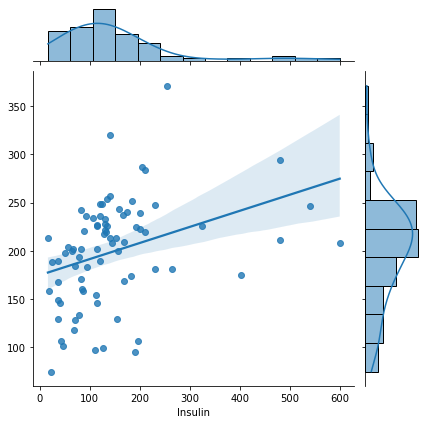

In [256]:
# jointplot 으로 실제값과 예측값을 시각화 합니다.
sns.jointplot(x = y_test, y=y_predict, kind='reg')
plt.show()

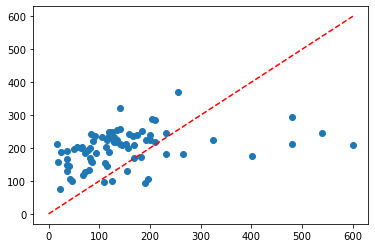

In [257]:
plt.scatter(x = result['Truth'], y = result['Pred'])
plt.plot([0,600],[0,600], color='r', linestyle='--')
plt.show()

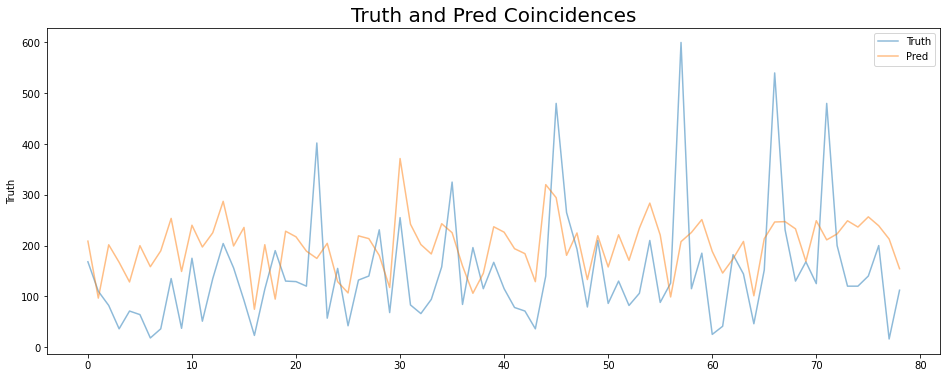

In [258]:
plt.figure(figsize=(16,6))
sns.lineplot(x = result.index, y = result['Truth'], alpha=0.5, label='Truth')
sns.lineplot(x = result.index, y = result['Pred'], alpha=0.5, label='Pred')
plt.title('Truth and Pred Coincidences',size=20)
plt.legend(loc='upper right')
plt.show()

In [259]:
upper, lower= np.quantile(result['Error'].values,0.75), np.quantile(result['Error'].values,0.25)
iqr = upper-lower
boundary = upper + iqr*1.5
print('boundary :',np.round(boundary,4))

boundary : 34489.6833


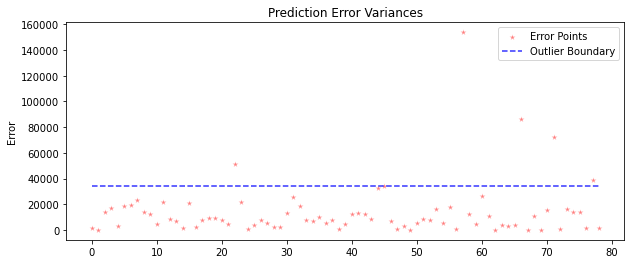

In [260]:
plt.figure(figsize=(10,4))
sns.scatterplot(x = result.index, y = result['Error'], color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(x = result.index, y = boundary, color='blue', linestyle='--', label='Outlier Boundary', alpha=0.8)
plt.title('Prediction Error Variances')
plt.legend(loc="upper right")
plt.show()

### MAE(Mean Absolute Error)
* [Mean absolute error - Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_error)

In [261]:
# 예측값과 실제값의 차이에 대한 절대값의 평균
error = result['Truth'] - result['Pred']
np.abs(error).mean()

99.35578252092192

### MAPE(Mean Absolute Percentage Error)

In [262]:
# (실제값 - 예측값 / 실제값)의 절대값에 대한 평균
# mape
np.abs(error / result['Pred']).mean()

0.509020834876145

### MSE(Mean Squared Error)

In [263]:
# 실제값 - 예측값의 차이의 제곱의 평균
# MAE와 비슷해 보이나 제곱을 통해 음수를 양수로 변환함
# 분산과 유사한 공식
# mse 
(error**2).mean()

13989.624341985425

### RMSE(Root Mean Squared Error)

In [264]:
# MSE 값에 Root를 취함, 표준편차와 유사한 공식
np.sqrt((error**2).mean())

118.27774237778394